Makemore pt3
Use an RNN to model a character level language model.
[Video](https://www.youtube.com/watch?v=P6sfmUTpUmc&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=4)

In [31]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import random

In [32]:
# Mac OS GPU acceleration or CPU
device = torch.device("cpu" if torch.backends.mps.is_available() else "cpu")
print(device)

cpu


In [33]:
# Load names from file
words = open('names.txt', 'r').read().splitlines()
print(words[:5])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia']
32033


In [34]:
# Create vocab of characters to integers
chars = sorted(list(set(''.join(words))))
stoi = {c: i+1 for i, c in enumerate(chars)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}
print('stoi', stoi)
print('itos', itos)
vocab_size = len(itos)


stoi {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itos {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [35]:
# Create dataset
block_size = 4 # char context length

def build_dataset(words):
    X, Y = [], [] # X = Data, Y = Target
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch] # next char to be predicted and added to context
            X.append(context)
            Y.append(ix)

            context = context[1:] + [ix]
    X = torch.tensor(X, device=device)
    Y = torch.tensor(Y, device=device)
    return X, Y

train_n = int(len(words) * 0.8)
dev_n = int(len(words) * 0.1)
test_n = len(words) - train_n - dev_n
random.shuffle(words)
train_words = words[:train_n]
dev_words = words[train_n:train_n+dev_n]
test_words = words[train_n+dev_n:]

train_X, train_Y = build_dataset(train_words)
dev_X, dev_Y = build_dataset(dev_words)
test_X, test_Y = build_dataset(test_words)

In [36]:
# Define the MLP
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g, device=device)
W1 = torch.randn((block_size * n_embd,n_hidden), generator=g, device=device)
b1 = torch.randn(n_hidden, generator=g, device=device)
W2 = torch.randn((n_hidden,vocab_size), generator=g, device=device) * 0.01 # intiialising to a lower loss (by lowering random values in weight and bias initialization) helps reduce loss by 0.1.
b2 = torch.randn(vocab_size, generator=g, device=device) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True


13897


  0%|          | 671/200000 [00:00<00:59, 3366.32it/s]

      0/ 200000 loss: 2.1103


  5%|▌         | 10694/200000 [00:03<00:54, 3476.02it/s]

  10000/ 200000 loss: 1.9816


 10%|█         | 20591/200000 [00:05<00:50, 3564.24it/s]

  20000/ 200000 loss: 2.4689


 15%|█▌        | 30623/200000 [00:08<00:47, 3600.71it/s]

  30000/ 200000 loss: 2.2476


 20%|██        | 40670/200000 [00:11<00:44, 3574.45it/s]

  40000/ 200000 loss: 2.8049


 25%|██▌       | 50704/200000 [00:14<00:41, 3558.64it/s]

  50000/ 200000 loss: 1.9230


 30%|███       | 60716/200000 [00:17<00:38, 3585.87it/s]

  60000/ 200000 loss: 1.9250


 35%|███▌      | 70432/200000 [00:20<00:36, 3576.33it/s]

  70000/ 200000 loss: 2.3680


 40%|████      | 80475/200000 [00:22<00:33, 3559.18it/s]

  80000/ 200000 loss: 2.0604


 45%|████▌     | 90529/200000 [00:25<00:30, 3572.88it/s]

  90000/ 200000 loss: 2.4831


 50%|█████     | 100587/200000 [00:28<00:27, 3571.78it/s]

 100000/ 200000 loss: 1.9565


 55%|█████▌    | 110637/200000 [00:31<00:25, 3569.83it/s]

 110000/ 200000 loss: 2.0877


 60%|██████    | 120678/200000 [00:34<00:22, 3596.75it/s]

 120000/ 200000 loss: 2.1818


 65%|██████▌   | 130389/200000 [00:36<00:19, 3576.40it/s]

 130000/ 200000 loss: 1.9540


 70%|███████   | 140472/200000 [00:39<00:16, 3593.09it/s]

 140000/ 200000 loss: 2.1615


 75%|███████▌  | 150530/200000 [00:42<00:13, 3580.59it/s]

 150000/ 200000 loss: 1.9529


 80%|████████  | 160505/200000 [00:45<00:12, 3276.52it/s]

 160000/ 200000 loss: 1.8973


 85%|████████▌ | 170440/200000 [00:48<00:08, 3443.22it/s]

 170000/ 200000 loss: 2.1555


 90%|█████████ | 180426/200000 [00:51<00:05, 3567.38it/s]

 180000/ 200000 loss: 1.9024


 95%|█████████▌| 190361/200000 [00:54<00:02, 3563.58it/s]

 190000/ 200000 loss: 1.8765


100%|██████████| 200000/200000 [00:56<00:00, 3518.72it/s]


(tensor(1.8540, grad_fn=<NllLossBackward0>),
 tensor([-3.6316,  2.0103,  0.5886,  0.7455,  0.6814,  0.9036, -0.2589, -0.0729,
         -0.0651, -0.0335,  1.0480,  1.8169,  0.7658,  1.2488,  0.6803, -0.7565,
         -0.5521, -2.0481,  0.5188,  1.1201,  0.5539, -1.9792, -0.5374, -0.7299,
         -1.8698, -0.4596,  0.4727], grad_fn=<SelectBackward0>))

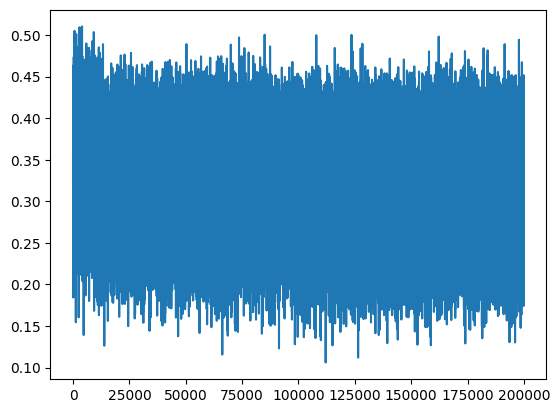

In [40]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in tqdm(range(max_steps)):
  
    # minibatch construct
    ix = torch.randint(0, train_X.shape[0], (batch_size,), generator=g)
    Xb, Yb = train_X[ix], train_Y[ix] # batch X,Y

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
    
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d} loss: {loss.item():.4f}')
    lossi.append(loss.log10().item())


# Plot
plt.plot(lossi)
loss, logits[0]

In [41]:
# Evaluation
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (train_X, train_Y),
        'dev': (dev_X, dev_Y),
        'test': (test_X, test_Y),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss.item():.4f}')
split_loss('train')
split_loss('dev')

train loss: 2.0905
dev loss: 2.1640


In [39]:
# Sampling from model
g = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[ix] for ix in out))

chrelle.
abriell.
kimliah.
atyah.
castie.
rahnen.
delyah.
jareli.
nelania.
chaiin.
kaleigh.
ham.
poru.
quintis.
lilea.
jadai.
wattho.
dearynix.
kheriilsa.
medde.
